<a href="https://colab.research.google.com/github/YuxingW/deep_learning/blob/main/hw4/part_2_mnist_classifier_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment
The assignment is to implement MNIST classifier fully with all the things learnt in last class with many features in keras in a colab.

###Detail requirements

(a) The code should do mini batch gradient descent along with appropriate learning rate and pick appropriate batch size for minibatch.
<br />
(b) The code should do dropout - try various dropout rates and pick the one which works well.
<br />
(c) The code should do basic image augmentations to supplement the training data (not testing data) using keras libraries.
<br />
(d) The code should use  3 or more layers for training (not 2 as in example ) - you have to tune and pick number of neurons in your layer and number of layers
<br />
(e) The code will continue to use relu activation layer in right places like python code
<br />
(f) The code should normalize the input as discussed in the class before training (scaling the input)
<br />
(g) The code should use appropriate learning rate (try out few to find out which one works) - you can use adaptive learning rates like different learning rates per epoch or per mini batch.
<br />
(h) The code should provide appropriate metrics, visualization,  testing and training accuracy etc.,. and plot the results and confusion matrix  (this is important)
<br />
(i) The code should display top common errors like in below link.

# Data preprocessing

##Load and preprocessing mnist image dataset

In [ ]:
import sys, numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

##Do image augmentations on the training data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale = 0) # no rescaling is applied

train_augment = datagen.flow(x_train.reshape(-1,28,28, 1), y = y_train)

Covert the type/shape of the augmentation data back to the same type/shape of x_train y_train

In [ ]:
batch_index = 0
x_list, y_list = [], []
while batch_index <= train_augment.batch_index:
    data = train_augment.next()
    x_list.append(data[0])
    y_list.append(data[1])
    batch_index = batch_index + 1

x_augment = np.asarray(x_list).reshape(-1,28, 28)
y_augment = np.asarray(y_list).reshape(-1, )

##Normalize data and covert labels to one hot labels
Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

In [ ]:
def convert_labels(labels):
  one_hot_labels = np.zeros((len(labels),10))
  for i,l in enumerate(labels):
      one_hot_labels[i][l] = 1
  return one_hot_labels

images, labels = (x_augment[0:60000].reshape(60000,28*28) / 255, y_augment[0:60000])
labels = convert_labels(labels)
x, y_true = images, labels

test_images, test_labels = x_test.reshape(len(x_test),28*28) / 255, y_test
test_labels = convert_labels(test_labels)
x_test, y_test = test_images, test_labels

print(f'images: {images.shape}, labels: {labels.shape}, test_images: {test_images.shape}, test_labels: {test_labels.shape}')

images: (60000, 784), labels: (60000, 10), test_images: (10000, 784), test_labels: (10000, 10)


#Model construction

##Construct neural network model using keras with dropout rate
The model is constructed with multiple convolutional layers relu and BatchNormalization, drop out rate as 0.3. <br />
Use categorical_crossentropy as loss function.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf

model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
#plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)        0

## Tune drop out rate
I have tried drop rate 0.2 0.3 on both relu layers, it appears they have the same effect on the final test accuracy of keras model.

# Model training

##Train the model with tuning mini batch and learning rate
Use dynamic learning rate, learning rate starts from 0.01 and decays continuously while epoch is increasing, which gets a better test accuracy than a fixed learning rate. <br />
Also, tried batch size 32 64 100, for this keras model, they do not affect the test accuracy which is 99%.

In [ ]:
import math

BATCH_SIZE = 32
EPOCHS = 10

# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(x, y_true, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    callbacks=[lr_decay_callback])

Steps per epoch:  1875
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
1875/1875 [==============================] - 85s 45ms/step - loss: 0.3921 - accuracy: 0.8768
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00666.
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0894 - accuracy: 0.9729
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004435560000000001.
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0603 - accuracy: 0.9817
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0029540829600000007.
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0454 - accuracy: 0.9862
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0019674192513600007.
1875/1875 [==============================] - 87s 46ms/step - loss: 0.0315 - accuracy: 0.9901
Epoch 6/10

Epoch 00006: LearningRateScheduler reducing learning

# Model evaluation

Evaluate the model with test accuracy

In [ ]:
model.evaluate(x_test, y_test, batch_size=64, verbose=1)

157/157 [==============================] - 4s 22ms/step - loss: 0.0201 - accuracy: 0.9934


[0.020099053159356117, 0.993399977684021]

## Plot confusion matrix

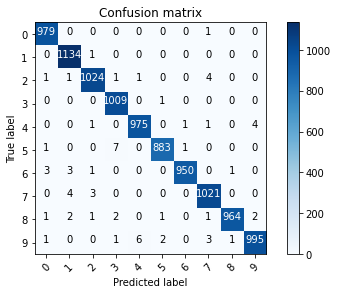

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

##Display top common errors

In [ ]:
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)


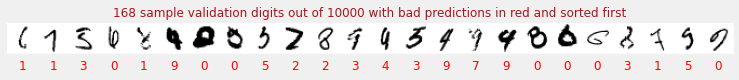

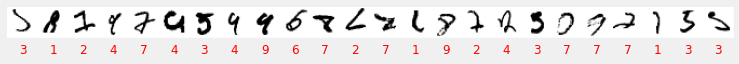

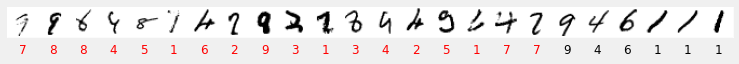

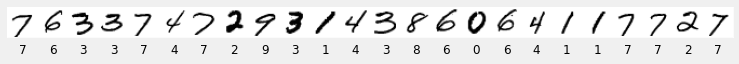

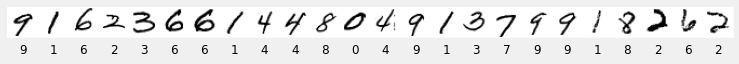

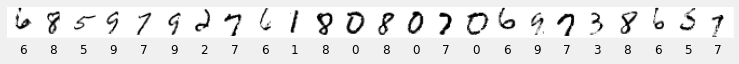

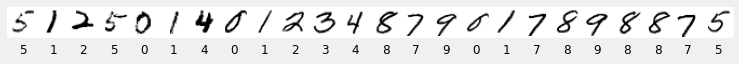

In [ ]:
# number of digits in one row
N = 24
# recognize validation digits
display_top_unrecognized(x_test, Y_pred_classes, Y_true, N, 7)

#Referrences
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 <br />
https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist#0

